In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [3]:
df_movies = pd.read_csv('movies.csv')

In [4]:


encoder = LabelEncoder()
labels = encoder.fit_transform(df_movies['genre'].values)
labels.shape

(54214,)

In [5]:
df_movies['label'] = labels

In [6]:

x_train, x_test, y_train, y_test = train_test_split(df_movies['description'].values, df_movies['label'].values, test_size = 0.2, random_state = 0)

In [7]:

vectorizer = TfidfVectorizer(stop_words='english', lowercase = True)
features = vectorizer.fit_transform(x_train) # training vector TF-IDF pada tiap data
features_test = vectorizer.transform(x_test)

In [8]:
print(np.unique(y_train,return_counts=True))
unique = np.unique(y_train,return_counts=True)[1]
weights = unique.max()/unique
weights

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26]), array([ 1067,   480,   625,   391,   213,  5950,   415, 10510, 10840,
         620,   256,   161,   196,  1780,   568,   221,   264,   149,
         727,   551,   508,  4023,   338,   310,  1267,   106,   835]))


array([ 10.15932521,  22.58333333,  17.344     ,  27.72378517,
        50.89201878,   1.82184874,  26.12048193,   1.03139867,
         1.        ,  17.48387097,  42.34375   ,  67.32919255,
        55.30612245,   6.08988764,  19.08450704,  49.04977376,
        41.06060606,  72.75167785,  14.91059147,  19.67332123,
        21.33858268,   2.69450659,  32.07100592,  34.96774194,
         8.55564325, 102.26415094,  12.98203593])

In [9]:


# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(features, y_train, test_size=0.2, random_state=42)

# Convert to PyTorch sparse tensors
X_train_sparse_tensor = torch.sparse.FloatTensor(
    torch.LongTensor([features.nonzero()[0], features.nonzero()[1]]),
    torch.FloatTensor(features.data),
    torch.Size(features.shape)
)

X_test_sparse_tensor = torch.sparse.FloatTensor(
    torch.LongTensor([features_test.nonzero()[0], features_test.nonzero()[1]]),
    torch.FloatTensor(features_test.data),
    torch.Size(features_test.shape)
)

# Convert labels to PyTorch tensors
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

# Create PyTorch DataLoader
train_dataset = TensorDataset(X_train_sparse_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_sparse_tensor, y_test_tensor)

# Batch size for DataLoader
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Now you can use train_loader and test_loader for training and testing your PyTorch model.

<ipython-input-9-0a3ae3b5b3c7>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  torch.LongTensor([features.nonzero()[0], features.nonzero()[1]]),
<ipython-input-9-0a3ae3b5b3c7>:5: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  X_train_sparse_tensor = torch.sparse.FloatTensor(


In [10]:
len(train_loader)

339

In [11]:


class TwoLayerLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(TwoLayerLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,dropout=0.5, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Input x: (batch_size, sequence_length, input_size)
        lstm_out, _ = self.lstm(x)

        # Extract the output from the last time step
        lstm_out_last = lstm_out[:, -1, :]

        # Fully connected layer
        output = self.fc(lstm_out_last)

        return output

# Example usage:
input_size = features[0].shape[1]
hidden_size = 27
output_size = 27
num_layers = 1

# Instantiate the model
lstm_model = TwoLayerLSTM(input_size, hidden_size, output_size, num_layers).cuda()

# Print the model architecture
print(lstm_model)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


TwoLayerLSTM(
  (lstm): LSTM(107041, 27, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=27, out_features=27, bias=True)
)


In [12]:



# Assuming you have already defined your model (MyModel) and instantiated it as 'model'
# Define your loss function
criterion = nn.CrossEntropyLoss(weight = torch.tensor(weights).float().cuda())

# Define your optimizer (equivalent to 'adam' in Keras)
optimizer = optim.Adam(lstm_model.parameters())

# Define your evaluation metric (equivalent to 'accuracy' in Keras)
def accuracy(predictions, targets):
    _, predicted = torch.max(predictions, 1)
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    return correct / total

# Assuming you have training data (train_loader) and validation data (val_loader)





In [19]:

# Training loop
epochs = 10  # Adjust as needed
history = []
for epoch in range(epochs):
    lstm_model.train()  # Set the model to training mode
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        reshaped_sparse_data = torch.unsqueeze(inputs, 1)
        dense_input = reshaped_sparse_data.to_dense()
        outputs = lstm_model(dense_input.float().cuda())  # Forward pass
        #print(outputs.dtype,targets.float().dtype)
        loss = criterion(outputs,targets.long().cuda())  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    # Validation loop (if you have validation data)
        history.append(loss.item())
    lstm_model.eval()  # Set the model to evaluation mode
    total_accuracy = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            reshaped_sparse_data = torch.unsqueeze(inputs, 1)
            dense_input = reshaped_sparse_data.to_dense()

            outputs = lstm_model(dense_input.cuda())
            total_accuracy += accuracy(outputs, targets.cuda())

    average_accuracy = total_accuracy / len(test_loader)

    # Print or log the average accuracy for this epoch
    print(f'Epoch {epoch + 1}/{epochs}, Validation Accuracy: {average_accuracy}')

Epoch 1/10, Validation Accuracy: 0.5544652957336781
Epoch 2/10, Validation Accuracy: 0.5556227779573368
Epoch 3/10, Validation Accuracy: 0.5542612718164189
Epoch 4/10, Validation Accuracy: 0.5509322478991596
Epoch 5/10, Validation Accuracy: 0.5546460892049128
Epoch 6/10, Validation Accuracy: 0.5500505009696186
Epoch 7/10, Validation Accuracy: 0.5492232950872656
Epoch 8/10, Validation Accuracy: 0.54733051874596
Epoch 9/10, Validation Accuracy: 0.547919360051713
Epoch 10/10, Validation Accuracy: 0.5454377424046541


In [18]:
torch.save(lstm_model,'lstm_model55.pth')

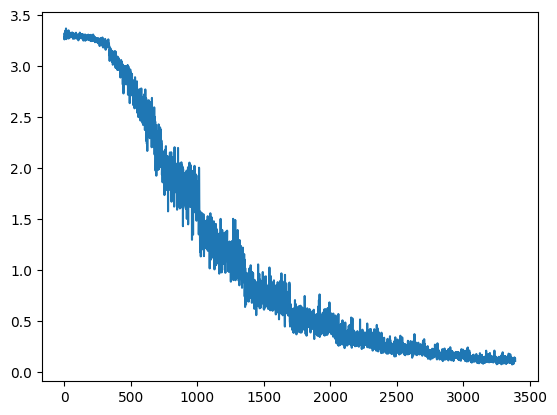

In [14]:
plt.plot(history)

In [15]:
total_accuracy = 0
with torch.no_grad():
  for inputs, targets in train_loader:
      reshaped_sparse_data = torch.unsqueeze(inputs, 1)
      dense_input = reshaped_sparse_data.to_dense()

      outputs = lstm_model(dense_input.cuda())
      total_accuracy += accuracy(outputs, targets.cuda())
total_accuracy / len(train_loader)


0.945184133170678

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

lstm_model.eval()

all_preds = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        # Forward pass
        reshaped_sparse_data = torch.unsqueeze(inputs, 1)
        dense_input = reshaped_sparse_data.to_dense()

        outputs = lstm_model(dense_input.cuda())

        # Get predicted labels
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



<ipython-input-17-4c54db45ed01>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  conf_matrix_log = np.zeros_like(conf_matrix, dtype=np.float)


<Figure size 1000x1000 with 0 Axes>

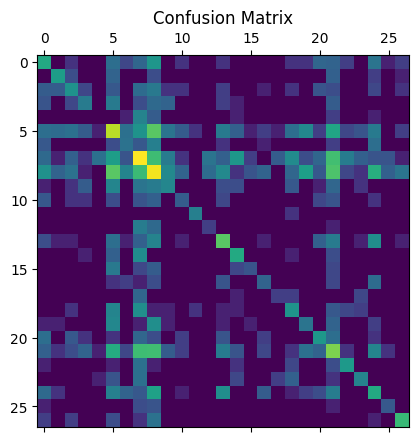

(27, 27)

In [17]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
conf_matrix_log = np.zeros_like(conf_matrix, dtype=np.float)
nonzero_indices = conf_matrix > 0
conf_matrix_log[nonzero_indices] = np.log(conf_matrix[nonzero_indices])
plt.figure(figsize=(10,10))
# Display the confusion matrix
class_names = [str(i) for i in range(27)]  # Replace with your actual class names
#disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
#disp.plot(cmap='viridis', values_format='d')
plt.matshow(conf_matrix_log)
plt.title('Confusion Matrix')

plt.show()
conf_matrix.shape